# eypsurv
This notes demonstrates the basic usage of `epysurv`

In [1]:
import sys
sys.path.append("..")

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from epysurv import data as epidata

In [3]:
plt.rc("figure", figsize=(16, 8))

## Data
Let's first get some data and plot it. We use the case counts of Salmonella Newport from Germany between 2004 and 2013. The data is already split into training and test set. We see that there are no outbreaks in the training set, but some around the end of 2011 in the test set.

In [4]:
train, test = epidata.salmonella()
train.head()

,n_cases,n_outbreak_cases,outbreak
2004-01-05,0,0,False
2004-01-12,0,0,False
2004-01-19,2,0,False
2004-01-26,2,0,False
2004-02-02,1,0,False


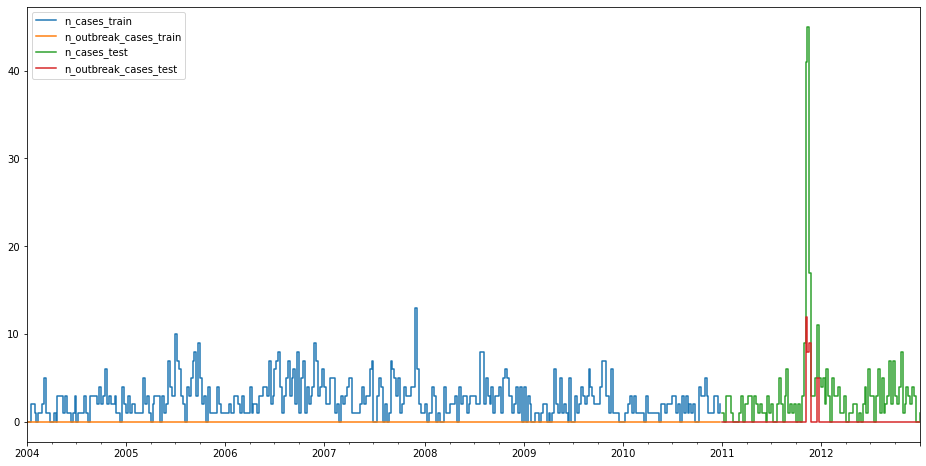

In [5]:
fig, ax = plt.subplots()
train.add_suffix("_train").plot(drawstyle="steps-post", ax=ax)
test.add_suffix("_test").plot(drawstyle="steps-post", ax=ax);

## Outbreak detection
Next we import some classical models: `EarsC1` and `FarringtonFlexible`. The API works really similiar to `scikit-learn`. Finally, we plot the predictions.

In [6]:
from epysurv.models.timepoint import EarsC1, FarringtonFlexible
from epysurv.visualization.model_diagnostics import plot_prediction, plot_confusion_matrix
from sklearn.metrics import confusion_matrix

C:\Users\AbboodA\AppData\Local\Continuum\miniconda3\envs\epysurv-dev\lib\site-packages\rpy2\robjects\pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [7]:
model = EarsC1()
model.fit(train)
pred = model.predict(test)
pred.head()

,n_cases,n_outbreak_cases,outbreak,alarm
2011-01-03,1,0,False,False
2011-01-10,0,0,False,False
2011-01-17,3,0,False,False
2011-01-24,3,0,False,False
2011-01-31,3,0,False,False


In [8]:
pred.query("alarm != 0")

,n_cases,n_outbreak_cases,outbreak,alarm
2011-08-01,5,0,False,True
2011-10-31,9,0,False,True
2011-11-07,41,12,True,True
2012-06-11,4,0,False,True
2012-06-25,6,0,False,True


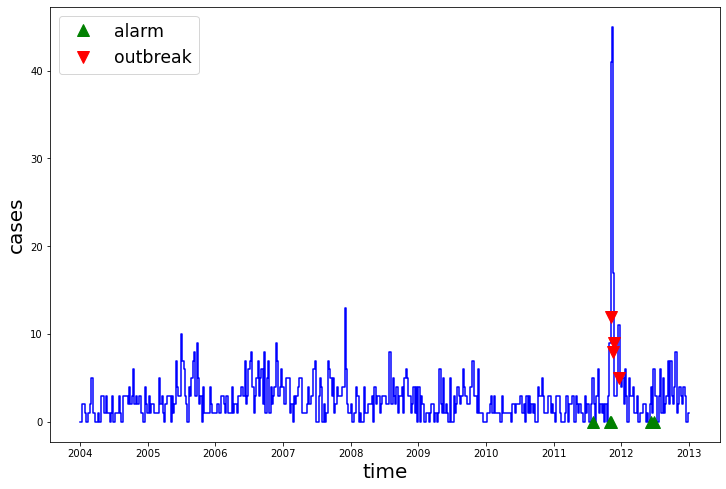

In [9]:
plot_prediction(train, test, pred);

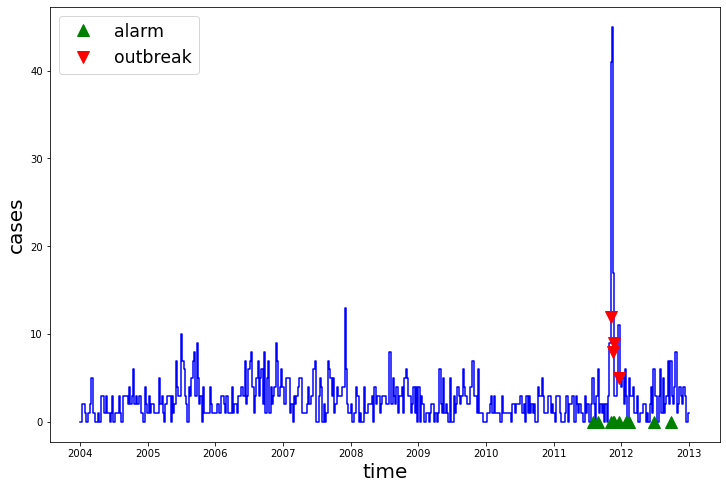

In [10]:
model = FarringtonFlexible()
model.fit(train)
pred = model.predict(test)
plot_prediction(train, test, pred);

By looking at the confusion matrix, we can see the the `FarringtonFlexible` successfully detected all outbreak, but also produced some false positives.

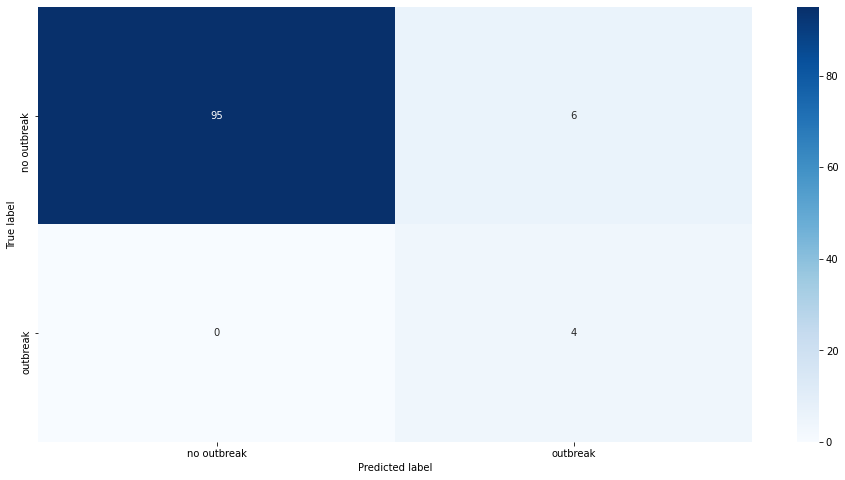

In [11]:
plot_confusion_matrix(confusion_matrix(test["outbreak"], pred["alarm"]), class_names=["no outbreak", "outbreak"]);

## Simulations
What if we don't have epidemiological data but want to test an outbreak detection algorithm? We can simulate data using a variaty of tunable paramters for endemic and epidemic data. In the following we are going to show two basic simulations with their standard paramters.

In [12]:
from epysurv.simulation.point_source import PointSource
from epysurv.simulation.seasonal_noise import SeasonalNoisePoisson

In [13]:
endemic_simulation = SeasonalNoisePoisson()
endemic_simulation.simulate(5)

,mean,n_cases,timestep
dates,,,
2020-01-06,3.066499,0,1
2020-01-13,3.453249,4,2
2020-01-20,3.875230,8,3
2020-01-27,4.326345,4,4
2020-02-03,4.797355,4,5


In [14]:
# This model randomly assigns outbreaks which are increase endemic case counts for that timestep
epidemic_simulation = PointSource()
epidemic_simulation.simulate(5)

,n_cases,is_outbreak,timestep
dates,,,
2020-01-06,2,0.0,1
2020-01-13,11,0.0,2
2020-01-20,4,0.0,3
2020-01-27,5,0.0,4
2020-02-03,10,0.0,5


In [15]:
# We can choose when an outbreak is supposed to happen by defining the state parameter
epidemic_simulation.simulate(5, state=[0,1,1,0,0])

,n_cases,is_outbreak,timestep
dates,,,
2020-01-06,4,0,1
2020-01-13,4,1,2
2020-01-20,4,1,3
2020-01-27,6,0,4
2020-02-03,2,0,5
